In [1]:
# !pip install opencv-python
# !pip install tensorflow
import os
import sys
import numpy as np
import re
import cv2

import matplotlib.pyplot as plt
import tensorflow as tf
from os import listdir
from tensorflow.keras.layers import *
from time import time
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import Model
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.xception import Xception


C:\Users\NITK\anaconda3\envs\Shyam_Lal\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Image 1 shape: (1024, 1024, 3)
Image 2 shape: (1024, 1024, 3)
Label shape: (1024, 1024)


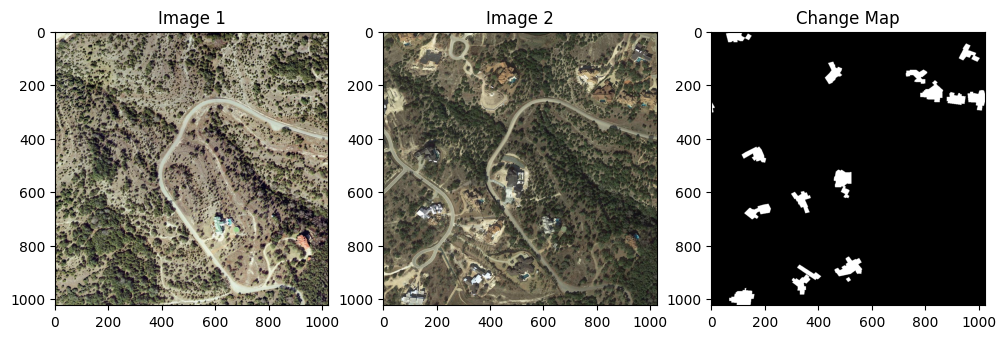

In [2]:
path = "D:/SujanD datasets/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD"
image1 = cv2.imread(os.path.join(path, 'val/A/val_13.png'))
image2 = cv2.imread(os.path.join(path, 'val/B/val_13.png'))
label = cv2.imread(os.path.join(path, 'val/label/val_13.png'), 0)
print("Image 1 shape:", image1.shape)
print("Image 2 shape:", image2.shape )
print("Label shape:", label.shape)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)); plt.title('Image 1')
plt.subplot(1,3,2); plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)); plt.title('Image 2')
plt.subplot(1,3,3); plt.imshow(label, cmap='gray'); plt.title('Change Map')
plt.show()


In [ ]:
def load_dataset_for_unetpp(X1_paths, X2_paths, Y_paths, img_size=(512, 512)):
    X_combined = []
    Y = []

    for p1, p2, pl in zip(X1_paths, X2_paths, Y_paths):
        img1 = cv2.imread(p1)
        img2 = cv2.imread(p2)
        label = cv2.imread(pl, cv2.IMREAD_GRAYSCALE)

        img1 = cv2.resize(img1, img_size)
        img2 = cv2.resize(img2, img_size)
        label = cv2.resize(label, img_size, interpolation=cv2.INTER_NEAREST)

        img1 = img1.astype(np.float32) / 255.0
        img2 = img2.astype(np.float32) / 255.0

        combined = np.concatenate([img1, img2], axis=-1)

        label = (label > 127).astype(np.uint8)

        label_onehot = np.zeros((*img_size, 2), dtype=np.float32)
        label_onehot[..., 0] = (label == 0)
        label_onehot[..., 1] = (label == 1)

        X_combined.append(combined)
        Y.append(label_onehot)

    X_combined = np.stack(X_combined, axis=0)
    Y = np.stack(Y, axis=0)

    return X_combined, Y



In [ ]:
import os
import cv2
import numpy as np
import glob


train_A_folder = r"D:\SujanD datasets\datasets\mdrifaturrahman33\levir-cd\versions\1\LEVIR CD\train\A_resized"
train_B_folder = "D:/SujanD datasets/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/train/B_resized"
train_label_folder = "D:/SujanD datasets/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/train/label_resized"
train_A_paths = sorted(glob.glob(os.path.join(train_A_folder, "*.png")))
train_B_paths = sorted(glob.glob(os.path.join(train_B_folder, "*.png")))
train_label_paths = sorted(glob.glob(os.path.join(train_label_folder, "*.png")))

test_A_folder = r"D:/SujanD datasets/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/test/A_resized"
test_B_folder = r"D:/SujanD datasets/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/test/B_resized"
test_L_folder = r"D:/SujanD datasets/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/test/label_resized"
test_A_paths = sorted(glob.glob(os.path.join(test_A_folder, "*.[pP][nN][gG]")))
test_B_paths = sorted(glob.glob(os.path.join(test_B_folder, "*.[pP][nN][gG]")))
test_L_paths = sorted(glob.glob(os.path.join(test_L_folder, "*.[pP][nN][gG]")))

val_A_folder = r"D:/SujanD datasets/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/val/A_resized"
val_B_folder = r"D:/SujanD datasets/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/val/B_resized"
val_L_folder = r"D:/SujanD datasets/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/val/label_resized"
val_A_paths = sorted(glob.glob(os.path.join(val_A_folder, "*.[pP][nN][gG]")))
val_B_paths = sorted(glob.glob(os.path.join(val_B_folder, "*.[pP][nN][gG]")))
val_L_paths = sorted(glob.glob(os.path.join(val_L_folder, "*.[pP][nN][gG]")))

X_train, y_train = load_dataset_for_unetpp(train_A_paths, train_B_paths, train_label_paths)
X_val, y_val     = load_dataset_for_unetpp(val_A_paths, val_B_paths, val_L_paths)

y_train_bin = y_train[..., 1:2]
y_val_bin   = y_val[..., 1:2]


MemoryError: Unable to allocate 10.4 GiB for an array with shape (1780, 512, 512, 6) and data type float32

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation, Add
from tensorflow.keras.models import Model

def UnetPP (input_shape=(512,512,6)):
    inputs = Input(shape=input_shape)

    x00=Conv2D(32,3,padding='same',activation='selu',)(inputs)
    x00=BatchNormalization()(x00)

    x10 = MaxPooling2D()(x00)
    x10=Conv2D(64,3,padding='same',activation='selu')(x10)
    x10=BatchNormalization()(x10)

    x20 = MaxPooling2D()(x10)
    x20=Conv2D(128,3,padding='same',activation='selu')(x20)
    x20=BatchNormalization()(x20)

    x30 = MaxPooling2D()(x20)
    x30=Conv2D(256,3,padding='same',activation='selu')(x30)
    x30=BatchNormalization()(x30)

    x40 = MaxPooling2D()(x30)
    x40=Conv2D(512,3,padding='same',activation='selu')(x40)
    x40=BatchNormalization()(x40)

    x01=UpSampling2D()(x10)
    x01=Concatenate()([x00,x01])
    x01=Conv2D(32,3,padding='same',activation='selu')(x01)
    x01=BatchNormalization()(x01)
    out1=Conv2D(1,1,activation='sigmoid',name='Y0_1')(x01)
    x11=UpSampling2D()(x20)
    x11=Concatenate()([x10,x11])
    x11=Conv2D(64,3,padding='same',activation='selu',)(x11)
    x11=BatchNormalization()(x11)

    x02=UpSampling2D()(x11)
    x02=Concatenate()([x00,x01,x02])
    x02=Conv2D(32,3,padding='same',activation='selu',)(x02)
    x02=BatchNormalization()(x02)
    out2=Conv2D(1,1,activation='sigmoid',name='Y0_2')(x02)
    x21=UpSampling2D()(x30)
    x21=Concatenate()([x20,x21])
    x21=Conv2D(128,3,activation='selu',padding='same',)(x21)
    x21=BatchNormalization()(x21)

    x12=UpSampling2D()(x21)
    x12=Concatenate()([x10,x11,x12])
    x12=Conv2D(64,3,padding='same',activation='selu',)(x12)
    x12=BatchNormalization()(x12)

    x03=UpSampling2D()(x12)
    x03=Concatenate()([x00,x01,x02,x03])
    x03=Conv2D(32,3,padding='same',activation='selu',)(x03)
    x03=BatchNormalization()(x03)
    out3=Conv2D(1,1,activation='sigmoid',name='Y0_3')(x03)
    x31 = UpSampling2D()(x40)
    x31 = Concatenate()([x30, x31])
    x31 = Conv2D(256, 3, padding='same')(x31)
    x31 = BatchNormalization()(x31)
    x31 = Activation('selu')(x31)

    x22 = UpSampling2D()(x31)
    x22 = Concatenate()([x20, x21, x22])
    x22 = Conv2D(128, 3, padding='same')(x22)
    x22 = BatchNormalization()(x22)
    x22 = Activation('selu')(x22)

    x13 = UpSampling2D()(x22)
    x13 = Concatenate()([x10, x11, x12, x13])
    x13 = Conv2D(64, 3, padding='same')(x13)
    x13 = BatchNormalization()(x13)
    x13 = Activation('selu')(x13)

    x04 = UpSampling2D()(x13)
    x04 = Concatenate()([x00, x01, x02, x03, x04])
    x04 = Conv2D(32, 3, padding='same')(x04)
    x04 = BatchNormalization()(x04)
    x04 = Activation('selu')(x04)
    out4=Conv2D(1,1,activation='sigmoid',name='Y0_4')(x04)

    fusion = Concatenate()([out1, out2, out3, out4])
    fusion = Conv2D(1, 1, activation='sigmoid',name='Y0_5')(fusion)
    model = Model(inputs, [out1, out2, out3, out4, fusion])
    return model

In [9]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce + d_loss

In [10]:
model = UnetPP(input_shape=(512, 512, 6))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={
        'Y0_1': bce_dice_loss,
        'Y0_2': bce_dice_loss,
        'Y0_3': bce_dice_loss,
        'Y0_4': bce_dice_loss,
        'Y0_5': bce_dice_loss
    },
    metrics={
        'Y0_1': ['accuracy', dice_loss],
        'Y0_2': ['accuracy', dice_loss],
        'Y0_3': ['accuracy', dice_loss],
        'Y0_4': ['accuracy', dice_loss],
        'Y0_5': ['accuracy', dice_loss]
    }
)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 6) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 1760        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
checkpoint = ModelCheckpoint(
    filepath="D:/SujanD check Saves/U++again.h5", 
    monitor="val_loss", 
    save_best_only=True, 
    save_weights_only=False, 
    verbose=1
)

earlystop = EarlyStopping(
    monitor="val_loss",
    patience=10, 
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)


history = model.fit(
    x=X_train, 
    y=[y_train_bin]*5,  
    validation_data=(X_val, [y_val_bin]*5),
    batch_size=1,
    epochs=50,
    callbacks=[checkpoint, earlystop, reduce_lr]
)


Epoch 1/50
1780/1780 [==============================] - 297s 162ms/step - loss: 6.4746 - Y0_1_loss: 1.3512 - Y0_2_loss: 1.3130 - Y0_3_loss: 1.2633 - Y0_4_loss: 1.0906 - Y0_5_loss: 1.4565 - Y0_1_accuracy: 0.8372 - Y0_1_dice_loss: 0.8848 - Y0_2_accuracy: 0.8562 - Y0_2_dice_loss: 0.8654 - Y0_3_accuracy: 0.8769 - Y0_3_dice_loss: 0.8384 - Y0_4_accuracy: 0.9208 - Y0_4_dice_loss: 0.8004 - Y0_5_accuracy: 0.9527 - Y0_5_dice_loss: 0.9536 - val_loss: 5.5653 - val_Y0_1_loss: 1.0700 - val_Y0_2_loss: 1.0819 - val_Y0_3_loss: 1.0478 - val_Y0_4_loss: 0.8587 - val_Y0_5_loss: 1.5069 - val_Y0_1_accuracy: 0.9456 - val_Y0_1_dice_loss: 0.8441 - val_Y0_2_accuracy: 0.9498 - val_Y0_2_dice_loss: 0.8270 - val_Y0_3_accuracy: 0.9484 - val_Y0_3_dice_loss: 0.7933 - val_Y0_4_accuracy: 0.9641 - val_Y0_4_dice_loss: 0.7169 - val_Y0_5_accuracy: 0.9475 - val_Y0_5_dice_loss: 0.9510

Epoch 00001: val_loss improved from inf to 5.56531, saving model to D:/SujanD check Saves\U++again.h5
Epoch 2/50
1780/1780 [===================

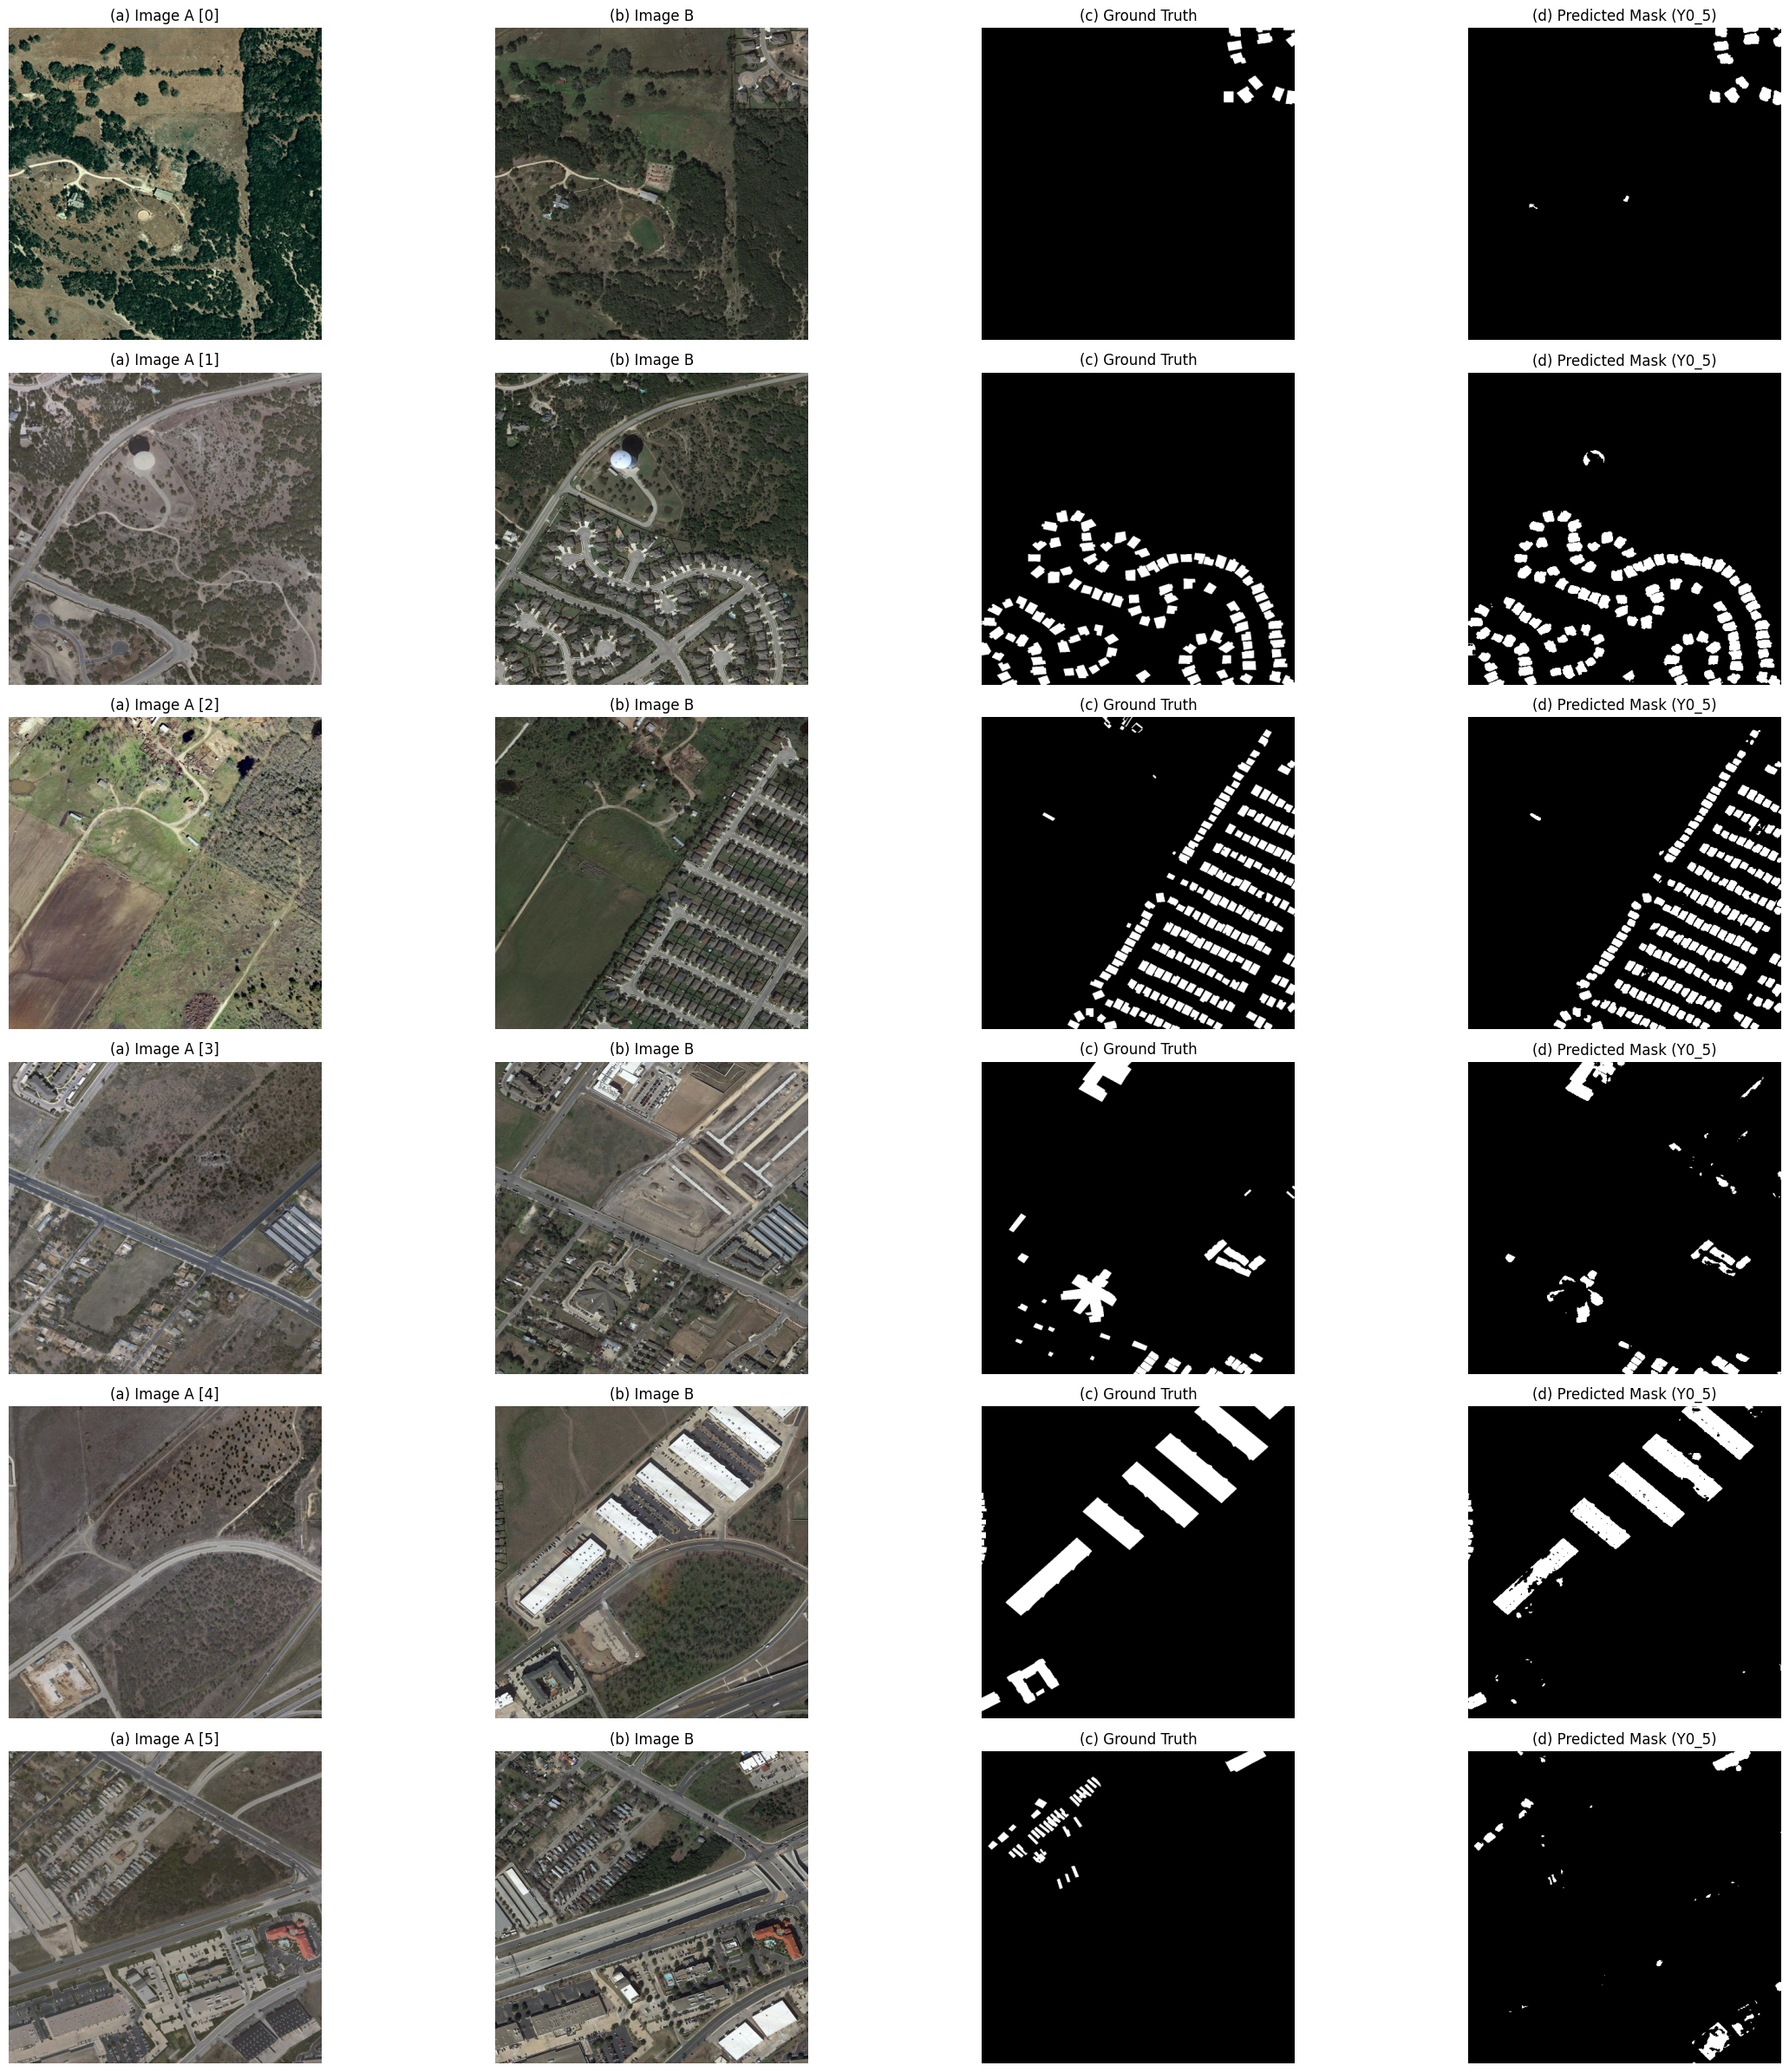

In [ ]:
def predict_and_plot_unetpp(model, A_paths, B_paths, label_paths, num_samples=6):
    plt.figure(figsize=(24, num_samples * 4))

    for i in range(num_samples):
        idx = i
        imgA = cv2.imread(A_paths[idx])
        imgB = cv2.imread(B_paths[idx])
        gt = cv2.imread(label_paths[idx], 0)

        imgA_resized = cv2.resize(imgA, (512, 512)).astype('float32') / 255.0
        imgB_resized = cv2.resize(imgB, (512, 512)).astype('float32') / 255.0

        input_combined = np.concatenate([imgA_resized, imgB_resized], axis=-1)
        input_combined = np.expand_dims(input_combined, axis=0) 

        preds = model.predict(input_combined)
        pred = preds[-1][0] 
        pred_mask = (pred[..., 0] > 0.5).astype(np.uint8) * 255

        plt.subplot(num_samples, 4, i * 4 + 1)
        plt.imshow(cv2.cvtColor(imgA, cv2.COLOR_BGR2RGB))
        plt.title(f"(a) Image A [{idx}]")
        plt.axis('off')

        plt.subplot(num_samples, 4, i * 4 + 2)
        plt.imshow(cv2.cvtColor(imgB, cv2.COLOR_BGR2RGB))
        plt.title("(b) Image B")
        plt.axis('off')

        plt.subplot(num_samples, 4, i * 4 + 3)
        plt.imshow(gt, cmap='gray')
        plt.title("(c) Ground Truth")
        plt.axis('off')

        plt.subplot(num_samples, 4, i * 4 + 4)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("(d) Predicted Mask (Y0_5)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
predict_and_plot_unetpp(model, test_A_paths, test_B_paths, test_L_paths, num_samples=6)


In [ ]:
y_pred = model.predict(X_val, batch_size=4)

if isinstance(y_pred, list):
    y_pred = np.concatenate(y_pred, axis=0)


In [ ]:
from sklearn.metrics import cohen_kappa_score, jaccard_score

def evaluate_change_detection(X_val, y_val_bin, threshold=0.5):
    y_pred = model.predict(X_val, batch_size=4)[-1]

    y_pred_bin = (y_pred > threshold).astype(np.uint8)
    y_true_bin = y_val_bin.astype(np.uint8)

    assert y_pred_bin.shape == y_true_bin.shape, f"Shape mismatch: {y_pred_bin.shape} vs {y_true_bin.shape}"

    y_pred_flat = y_pred_bin.flatten()
    y_true_flat = y_true_bin.flatten()

    TP = np.sum((y_true_flat == 1) & (y_pred_flat == 1))
    TN = np.sum((y_true_flat == 0) & (y_pred_flat == 0))
    FP = np.sum((y_true_flat == 0) & (y_pred_flat == 1))
    FN = np.sum((y_true_flat == 1) & (y_pred_flat == 0))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP + 1e-7)
    recall = TP / (TP + FN + 1e-7)
    f1 = 2 * precision * recall / (precision + recall + 1e-7)
    iou = TP / (TP + FP + FN + 1e-7)
    kappa = cohen_kappa_score(y_true_flat, y_pred_flat)

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"IoU:       {iou:.4f}")
    print(f"Kappa:     {kappa:.4f}")


In [35]:
evaluate_change_detection(X_val, y_val[..., 1:2])


Accuracy:  0.9809
Precision: 0.9133
Recall:    0.7028
F1 Score:  0.7943
IoU:       0.6588
Kappa:     0.7845


In [27]:
print("y_pred shape:", y_pred.shape)
print("y_val_bin shape:", y_val_bin.shape)


y_pred shape: (5, 128, 512, 512, 1)
y_val_bin shape: (128, 512, 512, 1)
